In [5]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
os.chdir('../src')

from models.diffusion import Diffusion, CondDiffusion
from models.guidance import Guidance
from models.unet import Unet
from models.condunet import condUnet

reverse_transform = transforms.Compose([transforms.Lambda(lambda x: (x+1)/2), transforms.ToPILImage()])
torch.manual_seed(0)

In [6]:
model_path = '../outputs/models/guided_fashion_mnist_diffusion_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

unet = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=11,
)
unet.load_state_dict(torch.load(model_path))

guided_diffusion = Guidance(
    model=unet,
    data_shape=data_shape,
    T=T,
    device=device,
    noise_schedule='linear'
)

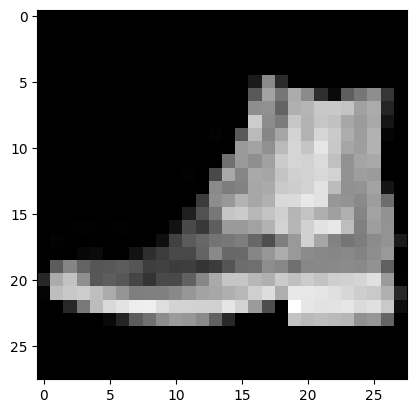

In [26]:
i = 9
label = torch.tensor([i]).to(device)
sample = guided_diffusion.sample(label, w=1).squeeze(0)
sample = reverse_transform(sample)
plt.imshow(sample, cmap='gray')

In [ ]:
model_path = '../outputs/models/mnist_diffusion_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

unet = Unet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
)
unet.load_state_dict(torch.load(model_path))

diffusion = Diffusion(
    model=unet,
    data_shape=data_shape,
    T=T,
    device=device,
)

In [ ]:
# generate samples
sample = diffusion.sample().squeeze(0)
sample = reverse_transform(sample)
plt.imshow(sample, cmap='gray')

In [ ]:
model_path = '../outputs/models/cond_mnist_diffusion_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=10,
)
net.load_state_dict(torch.load(model_path))

mnist_cond_diffusion = CondDiffusion(
    model=net,
    data_shape=data_shape,
    T=T,
    device=device,
)

In [ ]:
# generate samples
for i in range(10):
    label = torch.tensor([i]).to(device)
    sample = mnist_cond_diffusion.sample(label).squeeze(0)
    sample = reverse_transform(sample)
    plt.imshow(sample, cmap='gray')
    plt.savefig(f'../outputs/images/mnist_cond_diffusion_generated_{i}.png')

In [15]:
model_path = '../outputs/models/cond_fashion_mnist_diffusion_linear_sched_epoch_19.pt'

# model params
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_shape = (28, 28)
channels = 1
dim_mults = (1, 2, 4, )
T = 300

net = condUnet(
    dim=data_shape[0],
    channels=channels,
    dim_mults=dim_mults,
    num_classes=10,
)
net.load_state_dict(torch.load(model_path))

fashion_mnist_cond_diffusion = CondDiffusion(
    model=net,
    data_shape=data_shape,
    noise_schedule='linear',
    T=T,
    device=device,
)

In [ ]:
# generate samples
for i in range(10):
    label = torch.tensor([i]).to(device)
    sample = fashion_mnist_cond_diffusion.sample(label).squeeze(0)
    sample = reverse_transform(sample)
    plt.imshow(sample, cmap='gray')
    plt.savefig(f'../outputs/images/fashion_mnist_cond_diffusion_generated_{i}.png')

In [ ]:
def interleaved_label_sample(noise, labels, ts, model):
    assert len(labels) == len(ts)
    x_0 = noise
    x_t = x_0
    for label, t in zip(labels, ts):
        t = torch.tensor([t]).to(model.device)
        x_t = model.sample_p_t(x_t, t, label)
    return x_t

In [ ]:
# Generate samples from the notion page under header 

### Exploring Class-Conditional Denoising ###

label_a = 0
label_b = 1

# noises = fashion_mnist_cond_diffusion.explicit_sample(label_a)
samples = []
ts = list(reversed(range(fashion_mnist_cond_diffusion.T)))
noises = fashion_mnist_cond_diffusion.explicit_sample(label_a)
for i in tqdm(range(0, fashion_mnist_cond_diffusion.T, 30)):
    noise = noises[i]
    remaining_denoising_steps = fashion_mnist_cond_diffusion.T-i
    labels = torch.tensor([label_b]*remaining_denoising_steps).to(fashion_mnist_cond_diffusion.device)
    ts_cur = ts[-remaining_denoising_steps:]
    sample = interleaved_label_sample(noise, labels, ts_cur, fashion_mnist_cond_diffusion)
    samples.append(sample)